In [1]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import nibabel as nib
from PIL import Image
import os
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import MeanIoU
import cv2

2023-01-19 13:28:56.132907: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 13:28:58.205167: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-19 13:28:58.205390: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-01-19 13:28:58.205398: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
def NormalizeData(data):
    Norm_data = []
    for i in range(data.shape[0]):
        norm = cv2.normalize(data[i],None, alpha=0, beta=1,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        Norm_data.append(norm)
        
    return np.array(Norm_data)
        

In [3]:
def binbary_label(data):
    bin_data = []
    for i in range(data.shape[0]):
        img = data[i]
        bin_img = np.where(img>0,1,img)
        bin_data.append(bin_img)
#         chk = np.where(bin_img==1)
#         if len(chk)>5:
#             bin_data.append(bin_img)
    return np.array(bin_data)

In [4]:
def LoadData(p1,p2):
    data_ = nib.load(p1).get_fdata()
    data = np.transpose(data_,(2,0,1))
    label_ = nib.load(p2).get_fdata()
    label = np.transpose(label_,(2,0,1))
    
    unmask = NormalizeData(data)
    mask = binbary_label(label)
    return unmask,mask

In [5]:
def split_filename(filepath):
    path = os.path.dirname(filepath)
    filename = os.path.basename(filepath)
    base, ext = os.path.splitext(filename)
    if ext == '.gz':
        base, ext2 = os.path.splitext(base)
        ext = ext2 + ext
    return path, base, ext

def ProcessImage(path_file,mode='None',norm=True):
    dataset = []
    try:
        fns = sorted(glob.glob(path_file))
        for fn in fns:
            _, base, ext = split_filename(fn)
            img = nib.load(fn).get_data().astype(np.float32).squeeze()
            if img.ndim != 3:
                print(f'Only 3D data supported. File {base}{ext} has dimension {img.ndim}. Skipping.')
                continue
            
            if mode =='mask':
                for i in range(img.shape[2]):
                    r_img =  img[:,:,i]
                    r_img = np.where(r_img>0,1,r_img)
                    dataset.append(r_img)
            
            else:
                for i in range(img.shape[2]):
                    I = Image.fromarray(img[:,:,i], mode='F')

                    oldmin = np.min(I)
                    oldmax = np.max(I)
                    oldrange = oldmax-oldmin

                    newmin = 0
                    newmax = 255
                    newrange = newmax-newmin
                    scale =(I-oldmin)/oldrange
                    if norm:
                        normal_img = ((newrange*scale) + newmin)/255.
                    else:
                        normal_img = ((newrange*scale) + newmin)

                    dataset.append(normal_img)


        return np.array(dataset)
    except Exception as e:
        print(e)
        return 1


In [6]:
def LoadData():
#     path_to_data = 'Task101_SCGM/imagesTr/*.nii*'
#     path_to_mask = 'Task101_SCGM/labelsTr/*.nii*'
    path_to_data = 'new_c/*.nii*'
    path_to_mask = 'new_s/*.nii*'
    unmask = ProcessImage(path_to_data,mode='unmask',norm=False)
    mask = ProcessImage(path_to_mask,mode='mask')
    return unmask,mask


In [ ]:
data,label = LoadData()

In [ ]:
Data = sorted(glob.glob('new_c/*'))
GT = sorted(glob.glob('new_s/*'))

data,label = LoadData(Data[2],GT[2])
print(data.shape)
print(label.shape)

In [7]:
import joblib as jlb
label,data=jlb.load("clean_mask_unmask")

In [8]:
unmask = np.expand_dims(data,axis=3)
mask = np.expand_dims(label,axis=3)

In [ ]:
print(unmask.shape)
print(mask.shape)

In [9]:
def downsample(filters, size, shape, apply_batchnorm=True):
    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same', batch_input_shape=shape, 
                             kernel_initializer='he_normal'))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.ReLU())

    return result

def upsample(filters, size, shape, apply_dropout=False):
    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2, batch_input_shape=shape,padding='same',
                                    kernel_initializer='he_normal'))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.2))

    result.add(tf.keras.layers.ReLU())

    return result

In [10]:
OUTPUT_CHANNELS = 1
def buildUNet():
    inputs = tf.keras.layers.Input(shape=[512,512,1])
#     ye duplicate begir
    down_stack = [
        downsample(32, 3, (None, 512, 512,1), apply_batchnorm=False), # (bs, 128, 128, 64)
        downsample(64, 3, (None, 256, 256, 32)), # (bs, 64, 64, 128)
        downsample(64, 3, (None, 128, 128, 64)), # (bs, 32, 32, 256)
        downsample(64, 3, (None, 64, 64, 64)),
        downsample(64, 3, (None, 32, 32, 64)), # (bs, 16, 16, 512)
        downsample(64, 3, (None, 16, 16, 64)), # (bs, 8, 8, 512)
        downsample(64, 3, (None, 8, 8, 64)), # (bs, 4, 4, 512)
        downsample(64, 3, (None, 4, 4, 64)), # (bs, 2, 2, 512)
        downsample(64, 3, (None, 2, 2, 64)), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(64, 3, (None, 1, 1, 64), apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(64, 3, (None, 2, 2, 128), apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(64, 3, (None, 4, 4, 128), apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(64, 3, (None, 8, 8, 128)), # (bs, 16, 16, 1024)
        upsample(64, 3, (None, 16, 16, 128)), # (bs, 32, 32, 512)
        upsample(32, 3, (None, 32, 32, 128)), # (bs, 64, 64, 256)
        upsample(32, 3, (None, 64, 64, 96)), # (bs, 128, 128, 128)
        upsample(32, 3, (None, 128, 128, 96)),
        upsample(16, 3, (None, 256, 256, 96)),
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 3,strides=2,padding='same',
                                           kernel_initializer=initializer,
                                           activation='sigmoid') # (bs, 256, 256, 1)

    x = inputs

    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

In [11]:
x_train,x_test,y_train,y_test = train_test_split(unmask,mask,test_size=0.2,random_state=0)

In [12]:
model = buildUNet()

2023-01-19 13:29:11.783951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 13:29:12.686933: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38172 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:25:00.0, compute capability: 8.0


In [13]:
#m_optimizer = tf.keras.optimizers.Adam(2e-4)
#model.compile(optimizer = m_optimizer, loss = loss_object, metrics = ['accuracy'])
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sequential_1 (Sequential)      (None, 128, 128, 64  18752       ['sequential[0][0]']             
                                )                                                             

In [ ]:
# ****with kfold

In [15]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
num_folds=5
x2 = np.concatenate((x_train,x_test))
y2 = np.concatenate((y_train,y_test))
all_iou = []
for train, test in KFold(num_folds).split(x2):
    xtrain,xtest=x2[train],x2[test]
    ytrain,ytest=y2[train],y2[test]
    model.fit(xtrain,ytrain,epochs=200,shuffle=True,verbose=2,batch_size=16,validation_data=(xtest,ytest))
    
    y_pred = model.predict(xtest)
    y_pred_th = y_pred > 0.5
    intersection = np.logical_and(ytest,y_pred_th)
    union = np.logical_or(ytest,y_pred_th)
    iou_score = np.sum(intersection) / np.sum(union)
    all_iou.append(iou_score)
    
    print("\nresult:\t",model.evaluate(xtest,ytest.astype('float32')),'\n')

Epoch 1/200


2023-01-19 13:29:26.630854: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/sequential_9/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-01-19 13:29:27.859673: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600
2023-01-19 13:29:28.370689: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-19 13:29:28.902799: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x5555715fd3f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-19 13:29:28.902847: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-PCIE-40GB, Compute Capability 8.0
2023-01-19 13:29:28.908927: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash repro

87/87 - 15s - loss: 0.4613 - accuracy: 0.9444 - val_loss: 1.3045 - val_accuracy: 0.7401 - 15s/epoch - 176ms/step
Epoch 2/200
87/87 - 3s - loss: 0.0613 - accuracy: 0.9849 - val_loss: 0.0626 - val_accuracy: 0.9823 - 3s/epoch - 38ms/step
Epoch 3/200
87/87 - 3s - loss: 0.0285 - accuracy: 0.9923 - val_loss: 0.0401 - val_accuracy: 0.9871 - 3s/epoch - 39ms/step
Epoch 4/200
87/87 - 3s - loss: 0.0195 - accuracy: 0.9945 - val_loss: 0.0236 - val_accuracy: 0.9920 - 3s/epoch - 38ms/step
Epoch 5/200
87/87 - 3s - loss: 0.0160 - accuracy: 0.9952 - val_loss: 0.0230 - val_accuracy: 0.9924 - 3s/epoch - 38ms/step
Epoch 6/200
87/87 - 3s - loss: 0.0147 - accuracy: 0.9954 - val_loss: 0.0575 - val_accuracy: 0.9775 - 3s/epoch - 38ms/step
Epoch 7/200
87/87 - 3s - loss: 0.0124 - accuracy: 0.9960 - val_loss: 0.0170 - val_accuracy: 0.9942 - 3s/epoch - 38ms/step
Epoch 8/200
87/87 - 3s - loss: 0.0125 - accuracy: 0.9959 - val_loss: 0.0146 - val_accuracy: 0.9951 - 3s/epoch - 38ms/step
Epoch 9/200
87/87 - 3s - loss: 0.

Epoch 68/200
87/87 - 3s - loss: 0.0042 - accuracy: 0.9981 - val_loss: 0.0056 - val_accuracy: 0.9977 - 3s/epoch - 38ms/step
Epoch 69/200
87/87 - 3s - loss: 0.0043 - accuracy: 0.9981 - val_loss: 0.0092 - val_accuracy: 0.9968 - 3s/epoch - 38ms/step
Epoch 70/200
87/87 - 3s - loss: 0.0043 - accuracy: 0.9980 - val_loss: 0.0059 - val_accuracy: 0.9976 - 3s/epoch - 39ms/step
Epoch 71/200
87/87 - 3s - loss: 0.0043 - accuracy: 0.9981 - val_loss: 0.0056 - val_accuracy: 0.9977 - 3s/epoch - 38ms/step
Epoch 72/200
87/87 - 3s - loss: 0.0043 - accuracy: 0.9980 - val_loss: 0.0061 - val_accuracy: 0.9975 - 3s/epoch - 38ms/step
Epoch 73/200
87/87 - 3s - loss: 0.0042 - accuracy: 0.9981 - val_loss: 0.0054 - val_accuracy: 0.9977 - 3s/epoch - 39ms/step
Epoch 74/200
87/87 - 3s - loss: 0.0041 - accuracy: 0.9981 - val_loss: 0.0063 - val_accuracy: 0.9975 - 3s/epoch - 39ms/step
Epoch 75/200
87/87 - 3s - loss: 0.0042 - accuracy: 0.9981 - val_loss: 0.0058 - val_accuracy: 0.9975 - 3s/epoch - 40ms/step
Epoch 76/200
87/

Epoch 135/200
87/87 - 3s - loss: 0.0033 - accuracy: 0.9985 - val_loss: 0.0059 - val_accuracy: 0.9978 - 3s/epoch - 38ms/step
Epoch 136/200
87/87 - 3s - loss: 0.0032 - accuracy: 0.9985 - val_loss: 0.0060 - val_accuracy: 0.9978 - 3s/epoch - 39ms/step
Epoch 137/200
87/87 - 3s - loss: 0.0032 - accuracy: 0.9985 - val_loss: 0.0057 - val_accuracy: 0.9979 - 3s/epoch - 38ms/step
Epoch 138/200
87/87 - 3s - loss: 0.0032 - accuracy: 0.9985 - val_loss: 0.0057 - val_accuracy: 0.9979 - 3s/epoch - 38ms/step
Epoch 139/200
87/87 - 3s - loss: 0.0032 - accuracy: 0.9985 - val_loss: 0.0061 - val_accuracy: 0.9978 - 3s/epoch - 38ms/step
Epoch 140/200
87/87 - 3s - loss: 0.0032 - accuracy: 0.9985 - val_loss: 0.0059 - val_accuracy: 0.9979 - 3s/epoch - 38ms/step
Epoch 141/200
87/87 - 3s - loss: 0.0032 - accuracy: 0.9985 - val_loss: 0.0058 - val_accuracy: 0.9978 - 3s/epoch - 38ms/step
Epoch 142/200
87/87 - 3s - loss: 0.0032 - accuracy: 0.9985 - val_loss: 0.0062 - val_accuracy: 0.9977 - 3s/epoch - 38ms/step
Epoch 14

87/87 - 3s - loss: 0.0025 - accuracy: 0.9989 - val_loss: 0.0046 - val_accuracy: 0.9983 - 3s/epoch - 40ms/step
Epoch 67/200
87/87 - 3s - loss: 0.0026 - accuracy: 0.9988 - val_loss: 0.0035 - val_accuracy: 0.9985 - 3s/epoch - 40ms/step
Epoch 68/200
87/87 - 3s - loss: 0.0025 - accuracy: 0.9989 - val_loss: 0.0035 - val_accuracy: 0.9985 - 3s/epoch - 39ms/step
Epoch 69/200
87/87 - 3s - loss: 0.0025 - accuracy: 0.9989 - val_loss: 0.0036 - val_accuracy: 0.9984 - 3s/epoch - 39ms/step
Epoch 70/200
87/87 - 3s - loss: 0.0025 - accuracy: 0.9989 - val_loss: 0.0036 - val_accuracy: 0.9985 - 3s/epoch - 40ms/step
Epoch 71/200
87/87 - 3s - loss: 0.0025 - accuracy: 0.9989 - val_loss: 0.0036 - val_accuracy: 0.9985 - 3s/epoch - 40ms/step
Epoch 72/200
87/87 - 3s - loss: 0.0025 - accuracy: 0.9989 - val_loss: 0.0036 - val_accuracy: 0.9985 - 3s/epoch - 40ms/step
Epoch 73/200
87/87 - 3s - loss: 0.0025 - accuracy: 0.9989 - val_loss: 0.0036 - val_accuracy: 0.9985 - 3s/epoch - 39ms/step
Epoch 74/200
87/87 - 3s - los

Epoch 133/200
87/87 - 3s - loss: 0.0023 - accuracy: 0.9990 - val_loss: 0.0044 - val_accuracy: 0.9983 - 3s/epoch - 40ms/step
Epoch 134/200
87/87 - 3s - loss: 0.0023 - accuracy: 0.9990 - val_loss: 0.0042 - val_accuracy: 0.9984 - 3s/epoch - 39ms/step
Epoch 135/200
87/87 - 3s - loss: 0.0023 - accuracy: 0.9990 - val_loss: 0.0043 - val_accuracy: 0.9984 - 3s/epoch - 40ms/step
Epoch 136/200
87/87 - 4s - loss: 0.0022 - accuracy: 0.9990 - val_loss: 0.0042 - val_accuracy: 0.9984 - 4s/epoch - 40ms/step
Epoch 137/200
87/87 - 3s - loss: 0.0022 - accuracy: 0.9990 - val_loss: 0.0043 - val_accuracy: 0.9984 - 3s/epoch - 40ms/step
Epoch 138/200
87/87 - 3s - loss: 0.0022 - accuracy: 0.9990 - val_loss: 0.0045 - val_accuracy: 0.9984 - 3s/epoch - 40ms/step
Epoch 139/200
87/87 - 3s - loss: 0.0023 - accuracy: 0.9990 - val_loss: 0.0043 - val_accuracy: 0.9984 - 3s/epoch - 40ms/step
Epoch 140/200
87/87 - 3s - loss: 0.0023 - accuracy: 0.9990 - val_loss: 0.0044 - val_accuracy: 0.9984 - 3s/epoch - 40ms/step
Epoch 14

87/87 - 3s - loss: 0.0021 - accuracy: 0.9991 - val_loss: 0.0052 - val_accuracy: 0.9983 - 3s/epoch - 39ms/step
Epoch 200/200
87/87 - 3s - loss: 0.0021 - accuracy: 0.9991 - val_loss: 0.0056 - val_accuracy: 0.9983 - 3s/epoch - 39ms/step
11/11 [==============================] - 0s 20ms/step - loss: 0.0056 - accuracy: 0.9983

result:	 [0.005620131269097328, 0.9982908368110657] 

Epoch 1/200
87/87 - 4s - loss: 0.0031 - accuracy: 0.9987 - val_loss: 0.0038 - val_accuracy: 0.9984 - 4s/epoch - 45ms/step
Epoch 2/200
87/87 - 3s - loss: 0.0028 - accuracy: 0.9988 - val_loss: 0.0025 - val_accuracy: 0.9989 - 3s/epoch - 38ms/step
Epoch 3/200
87/87 - 3s - loss: 0.0025 - accuracy: 0.9989 - val_loss: 0.0024 - val_accuracy: 0.9990 - 3s/epoch - 38ms/step
Epoch 4/200
87/87 - 3s - loss: 0.0024 - accuracy: 0.9989 - val_loss: 0.0023 - val_accuracy: 0.9990 - 3s/epoch - 38ms/step
Epoch 5/200
87/87 - 3s - loss: 0.0024 - accuracy: 0.9990 - val_loss: 0.0023 - val_accuracy: 0.9990 - 3s/epoch - 38ms/step
Epoch 6/200
8

Epoch 65/200
87/87 - 3s - loss: 0.0021 - accuracy: 0.9991 - val_loss: 0.0032 - val_accuracy: 0.9987 - 3s/epoch - 39ms/step
Epoch 66/200
87/87 - 3s - loss: 0.0021 - accuracy: 0.9991 - val_loss: 0.0033 - val_accuracy: 0.9987 - 3s/epoch - 39ms/step
Epoch 67/200
87/87 - 3s - loss: 0.0021 - accuracy: 0.9991 - val_loss: 0.0030 - val_accuracy: 0.9987 - 3s/epoch - 39ms/step
Epoch 68/200
87/87 - 3s - loss: 0.0020 - accuracy: 0.9991 - val_loss: 0.0030 - val_accuracy: 0.9988 - 3s/epoch - 39ms/step
Epoch 69/200
87/87 - 3s - loss: 0.0021 - accuracy: 0.9991 - val_loss: 0.0030 - val_accuracy: 0.9988 - 3s/epoch - 39ms/step
Epoch 70/200
87/87 - 3s - loss: 0.0021 - accuracy: 0.9991 - val_loss: 0.0032 - val_accuracy: 0.9987 - 3s/epoch - 39ms/step
Epoch 71/200
87/87 - 3s - loss: 0.0020 - accuracy: 0.9991 - val_loss: 0.0030 - val_accuracy: 0.9988 - 3s/epoch - 39ms/step
Epoch 72/200
87/87 - 3s - loss: 0.0020 - accuracy: 0.9991 - val_loss: 0.0030 - val_accuracy: 0.9988 - 3s/epoch - 39ms/step
Epoch 73/200
87/

Epoch 132/200
87/87 - 3s - loss: 0.0019 - accuracy: 0.9992 - val_loss: 0.0037 - val_accuracy: 0.9986 - 3s/epoch - 38ms/step
Epoch 133/200
87/87 - 3s - loss: 0.0019 - accuracy: 0.9992 - val_loss: 0.0037 - val_accuracy: 0.9986 - 3s/epoch - 39ms/step
Epoch 134/200
87/87 - 3s - loss: 0.0019 - accuracy: 0.9992 - val_loss: 0.0038 - val_accuracy: 0.9986 - 3s/epoch - 39ms/step
Epoch 135/200
87/87 - 3s - loss: 0.0019 - accuracy: 0.9992 - val_loss: 0.0038 - val_accuracy: 0.9986 - 3s/epoch - 38ms/step
Epoch 136/200
87/87 - 3s - loss: 0.0019 - accuracy: 0.9992 - val_loss: 0.0038 - val_accuracy: 0.9986 - 3s/epoch - 39ms/step
Epoch 137/200
87/87 - 3s - loss: 0.0019 - accuracy: 0.9992 - val_loss: 0.0037 - val_accuracy: 0.9986 - 3s/epoch - 39ms/step
Epoch 138/200
87/87 - 3s - loss: 0.0019 - accuracy: 0.9992 - val_loss: 0.0041 - val_accuracy: 0.9986 - 3s/epoch - 39ms/step
Epoch 139/200
87/87 - 3s - loss: 0.0019 - accuracy: 0.9992 - val_loss: 0.0037 - val_accuracy: 0.9986 - 3s/epoch - 39ms/step
Epoch 14

87/87 - 3s - loss: 0.0018 - accuracy: 0.9992 - val_loss: 0.0041 - val_accuracy: 0.9986 - 3s/epoch - 38ms/step
Epoch 199/200
87/87 - 3s - loss: 0.0018 - accuracy: 0.9992 - val_loss: 0.0043 - val_accuracy: 0.9985 - 3s/epoch - 38ms/step
Epoch 200/200
87/87 - 3s - loss: 0.0018 - accuracy: 0.9992 - val_loss: 0.0043 - val_accuracy: 0.9986 - 3s/epoch - 38ms/step
11/11 [==============================] - 0s 20ms/step - loss: 0.0043 - accuracy: 0.9986

result:	 [0.004251647274941206, 0.9985511898994446] 

Epoch 1/200
87/87 - 4s - loss: 0.0026 - accuracy: 0.9989 - val_loss: 0.0028 - val_accuracy: 0.9988 - 4s/epoch - 45ms/step
Epoch 2/200
87/87 - 3s - loss: 0.0024 - accuracy: 0.9990 - val_loss: 0.0020 - val_accuracy: 0.9991 - 3s/epoch - 38ms/step
Epoch 3/200
87/87 - 3s - loss: 0.0022 - accuracy: 0.9990 - val_loss: 0.0020 - val_accuracy: 0.9991 - 3s/epoch - 38ms/step
Epoch 4/200
87/87 - 3s - loss: 0.0021 - accuracy: 0.9991 - val_loss: 0.0020 - val_accuracy: 0.9991 - 3s/epoch - 38ms/step
Epoch 5/200

Epoch 64/200
87/87 - 3s - loss: 0.0019 - accuracy: 0.9992 - val_loss: 0.0030 - val_accuracy: 0.9988 - 3s/epoch - 38ms/step
Epoch 65/200
87/87 - 3s - loss: 0.0019 - accuracy: 0.9992 - val_loss: 0.0025 - val_accuracy: 0.9990 - 3s/epoch - 38ms/step
Epoch 66/200
87/87 - 3s - loss: 0.0019 - accuracy: 0.9992 - val_loss: 0.0028 - val_accuracy: 0.9989 - 3s/epoch - 39ms/step
Epoch 67/200
87/87 - 3s - loss: 0.0019 - accuracy: 0.9992 - val_loss: 0.0025 - val_accuracy: 0.9990 - 3s/epoch - 39ms/step
Epoch 68/200
87/87 - 3s - loss: 0.0019 - accuracy: 0.9992 - val_loss: 0.0029 - val_accuracy: 0.9988 - 3s/epoch - 39ms/step
Epoch 69/200
87/87 - 3s - loss: 0.0019 - accuracy: 0.9992 - val_loss: 0.0025 - val_accuracy: 0.9990 - 3s/epoch - 39ms/step
Epoch 70/200
87/87 - 3s - loss: 0.0019 - accuracy: 0.9992 - val_loss: 0.0025 - val_accuracy: 0.9989 - 3s/epoch - 39ms/step
Epoch 71/200
87/87 - 3s - loss: 0.0018 - accuracy: 0.9992 - val_loss: 0.0028 - val_accuracy: 0.9989 - 3s/epoch - 39ms/step
Epoch 72/200
87/

Epoch 131/200
87/87 - 3s - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0031 - val_accuracy: 0.9988 - 3s/epoch - 38ms/step
Epoch 132/200
87/87 - 3s - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0032 - val_accuracy: 0.9988 - 3s/epoch - 38ms/step
Epoch 133/200
87/87 - 3s - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0035 - val_accuracy: 0.9988 - 3s/epoch - 38ms/step
Epoch 134/200
87/87 - 3s - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0031 - val_accuracy: 0.9988 - 3s/epoch - 38ms/step
Epoch 135/200
87/87 - 3s - loss: 0.0018 - accuracy: 0.9992 - val_loss: 0.0033 - val_accuracy: 0.9988 - 3s/epoch - 38ms/step
Epoch 136/200
87/87 - 3s - loss: 0.0018 - accuracy: 0.9992 - val_loss: 0.0031 - val_accuracy: 0.9988 - 3s/epoch - 38ms/step
Epoch 137/200
87/87 - 3s - loss: 0.0018 - accuracy: 0.9992 - val_loss: 0.0032 - val_accuracy: 0.9988 - 3s/epoch - 38ms/step
Epoch 138/200
87/87 - 3s - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0032 - val_accuracy: 0.9988 - 3s/epoch - 38ms/step
Epoch 13

87/87 - 3s - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0043 - val_accuracy: 0.9986 - 3s/epoch - 40ms/step
Epoch 198/200
87/87 - 3s - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0036 - val_accuracy: 0.9987 - 3s/epoch - 39ms/step
Epoch 199/200
87/87 - 3s - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0039 - val_accuracy: 0.9987 - 3s/epoch - 39ms/step
Epoch 200/200
87/87 - 3s - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0039 - val_accuracy: 0.9987 - 3s/epoch - 39ms/step
11/11 [==============================] - 0s 20ms/step - loss: 0.0039 - accuracy: 0.9987

result:	 [0.0038894012104719877, 0.9986720085144043] 

Epoch 1/200
87/87 - 4s - loss: 0.0023 - accuracy: 0.9990 - val_loss: 0.0027 - val_accuracy: 0.9989 - 4s/epoch - 45ms/step
Epoch 2/200
87/87 - 3s - loss: 0.0021 - accuracy: 0.9991 - val_loss: 0.0018 - val_accuracy: 0.9992 - 3s/epoch - 39ms/step
Epoch 3/200
87/87 - 3s - loss: 0.0019 - accuracy: 0.9992 - val_loss: 0.0020 - val_accuracy: 0.9991 - 3s/epoch - 39ms/step
Epoch 4/

Epoch 63/200
87/87 - 3s - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0025 - val_accuracy: 0.9990 - 3s/epoch - 38ms/step
Epoch 64/200
87/87 - 3s - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0029 - val_accuracy: 0.9988 - 3s/epoch - 38ms/step
Epoch 65/200
87/87 - 3s - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0023 - val_accuracy: 0.9990 - 3s/epoch - 38ms/step
Epoch 66/200
87/87 - 3s - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0024 - val_accuracy: 0.9990 - 3s/epoch - 38ms/step
Epoch 67/200
87/87 - 3s - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0023 - val_accuracy: 0.9990 - 3s/epoch - 38ms/step
Epoch 68/200
87/87 - 3s - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0026 - val_accuracy: 0.9990 - 3s/epoch - 38ms/step
Epoch 69/200
87/87 - 3s - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0025 - val_accuracy: 0.9990 - 3s/epoch - 38ms/step
Epoch 70/200
87/87 - 3s - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0026 - val_accuracy: 0.9989 - 3s/epoch - 39ms/step
Epoch 71/200
87/

Epoch 130/200
87/87 - 3s - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.0028 - val_accuracy: 0.9989 - 3s/epoch - 38ms/step
Epoch 131/200
87/87 - 3s - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.0029 - val_accuracy: 0.9989 - 3s/epoch - 38ms/step
Epoch 132/200
87/87 - 3s - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.0028 - val_accuracy: 0.9989 - 3s/epoch - 38ms/step
Epoch 133/200
87/87 - 3s - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.0029 - val_accuracy: 0.9989 - 3s/epoch - 38ms/step
Epoch 134/200
87/87 - 3s - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0030 - val_accuracy: 0.9988 - 3s/epoch - 38ms/step
Epoch 135/200
87/87 - 3s - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.0035 - val_accuracy: 0.9987 - 3s/epoch - 38ms/step
Epoch 136/200
87/87 - 3s - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0032 - val_accuracy: 0.9988 - 3s/epoch - 39ms/step
Epoch 137/200
87/87 - 3s - loss: 0.0017 - accuracy: 0.9993 - val_loss: 0.0029 - val_accuracy: 0.9989 - 3s/epoch - 38ms/step
Epoch 13

87/87 - 3s - loss: 0.0015 - accuracy: 0.9993 - val_loss: 0.0031 - val_accuracy: 0.9988 - 3s/epoch - 38ms/step
Epoch 197/200
87/87 - 3s - loss: 0.0015 - accuracy: 0.9993 - val_loss: 0.0035 - val_accuracy: 0.9988 - 3s/epoch - 38ms/step
Epoch 198/200
87/87 - 3s - loss: 0.0015 - accuracy: 0.9993 - val_loss: 0.0032 - val_accuracy: 0.9988 - 3s/epoch - 38ms/step
Epoch 199/200
87/87 - 3s - loss: 0.0015 - accuracy: 0.9993 - val_loss: 0.0034 - val_accuracy: 0.9988 - 3s/epoch - 38ms/step
Epoch 200/200
87/87 - 3s - loss: 0.0016 - accuracy: 0.9993 - val_loss: 0.0034 - val_accuracy: 0.9988 - 3s/epoch - 38ms/step
11/11 [==============================] - 0s 19ms/step - loss: 0.0034 - accuracy: 0.9988

result:	 [0.0034264239948242903, 0.9987726807594299] 



In [16]:
all_iou

[0.9315723594450306,
 0.9425031703935356,
 0.9536761601873889,
 0.9554244957514629,
 0.9588030986056865]

In [17]:
np.mean(np.array(all_iou))

0.9483958568766209

In [ ]:
# without kfold

In [ ]:
def showsingleimage(img):
    print("min:",np.min(img))
    print("max:",np.max(img))
    plt.imshow(img)
    plt.show()

In [ ]:
history = model.fit(x_train,y_train,
                    batch_size=16,
                    verbose=1,
                    epochs=50,
                    validation_data=(x_test,y_test),
                    #class_weight=class_weights,
                    shuffle=False)

In [ ]:
def Plot_ACC_LOSS(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1,len(loss)+1)
    plt.plot(epochs,loss,'y',label='Traning loss')
    plt.plot(epochs,val_loss,'r',label='Validation loss')
    plt.title('Traning and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [ ]:
Plot_ACC_LOSS(history)
# model.save("seg-5class.hdf5")

In [ ]:

#n_class=1
_,acc = model.evaluate(x_test,y_test)
print("Accuracy is :",(acc * 100.0),"%")


# model.load_weights("seg-5class.hdf5")

y_pred = model.predict(x_test)

y_pred_th = y_pred > 0.5
intersection = np.logical_and(y_test,y_pred_th)
union = np.logical_or(y_test,y_pred_th)
iou_score = np.sum(intersection) / np.sum(union)
print("IoU score is:",iou_score) 


1/1 [==============================] - 0s 120ms/step


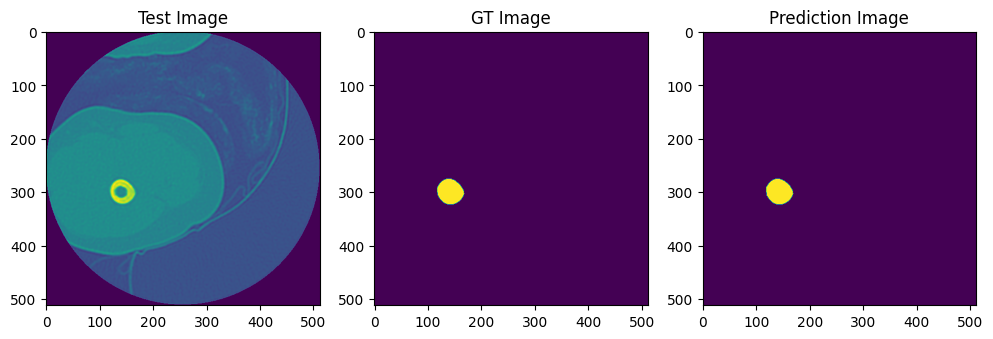

In [18]:
n_test_img = np.random.randint(0,len(x_test)-1)
test_img = x_test[n_test_img]
GT = y_test[n_test_img]
test_img_input = np.expand_dims(test_img,axis=0)
prediction = (model.predict(test_img_input)[0] > 0.5).astype(np.uint8)

plt.figure(figsize=(12,8))
plt.subplot(131)
plt.title('Test Image')
plt.imshow(test_img)
plt.subplot(132)
plt.title('GT Image')
plt.imshow(GT)
plt.subplot(133)
plt.title('Prediction Image')
plt.imshow(prediction)
plt.show()